In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

tf.random.set_seed(42)
np.random.seed(42)

igneous_rock_properties = {
    "Limestone":   {"velocity": (2.4, 0.1), "amplitude": (0.36, 0.02), "duration": (170, 10), "frequency_Hz": (26, 3)},
    "Sandstone":   {"velocity": (2.5, 0.1), "amplitude": (0.40, 0.02), "duration": (180, 10), "frequency_Hz": (28, 3)},
    "Shale":       {"velocity": (2.2, 0.1), "amplitude": (0.39, 0.02), "duration": (175, 10), "frequency_Hz": (25, 3)},
    "Siltstone":   {"velocity": (2.3, 0.1), "amplitude": (0.38, 0.02), "duration": (165, 10), "frequency_Hz": (24, 3)},
    "Chalk":       {"velocity": (2.1, 0.1), "amplitude": (0.37, 0.02), "duration": (170, 10), "frequency_Hz": (22, 3)},

}

def generate_dataset(props, samples_per_class=800, seed=42):
    """Generate dataset with more samples for better training"""
    np.random.seed(seed)
    data = []

    for rock_type, features in props.items():
        for _ in range(samples_per_class):
            row = {
                "rock_type": rock_type,
                "velocity": np.random.normal(*features["velocity"]),
                "amplitude": np.random.normal(*features["amplitude"]),
                "duration": np.random.normal(*features["duration"]),
                "frequency_Hz": np.random.normal(*features["frequency_Hz"])
            }
            data.append(row)

    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

df = generate_dataset(igneous_rock_properties)

df['velocity_x_amplitude'] = df['velocity'] * df['amplitude']
df['velocity_squared'] = df['velocity'] ** 2
df['duration_squared'] = df['duration'] ** 2
df['amplitude_duration'] = df['amplitude'] * df['duration']
df['velocity_frequency'] = df['velocity'] * df['frequency_Hz']
df['amplitude_frequency'] = df['amplitude'] * df['frequency_Hz']
df['duration_frequency'] = df['duration'] * df['frequency_Hz']
df['velocity_duration'] = df['velocity'] * df['duration']
df['amplitude_squared'] = df['amplitude'] ** 2
df['frequency_squared'] = df['frequency_Hz'] ** 2
df['velocity_amplitude_ratio'] = df['velocity'] / df['amplitude']
df['duration_frequency_ratio'] = df['duration'] / df['frequency_Hz']
df['velocity_duration_ratio'] = df['velocity'] / df['duration']
df['velocity_cubed'] = df['velocity'] ** 3
df['amplitude_cubed'] = df['amplitude'] ** 3

print(df)

      rock_type  velocity  amplitude    duration  frequency_Hz  \
0     Limestone  2.364166   0.347049  177.441920     25.456327   
1         Chalk  2.117872   0.366524  179.959549     24.208682   
2     Limestone  2.367138   0.372064  164.558860     25.511621   
3         Chalk  2.131816   0.378273  160.513781     22.219313   
4     Siltstone  2.438487   0.387933  156.668585     27.197891   
...         ...       ...        ...         ...           ...   
3995  Sandstone  2.451229   0.421487  184.964001     34.225195   
3996  Sandstone  2.369841   0.362940  178.751131     28.047093   
3997  Sandstone  2.514552   0.387718  181.409827     32.765881   
3998      Chalk  2.173976   0.399704  181.176324     23.505556   
3999  Siltstone  2.442326   0.377332  151.135106     22.428470   

      velocity_x_amplitude  velocity_squared  duration_squared  \
0                 0.820482          5.589281      31485.634872   
1                 0.776250          4.485380      32385.439378   
2        

In [29]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['rock_type'])
feature_cols = [
    'velocity', 'amplitude', 'duration', 'frequency_Hz',
    'velocity_x_amplitude', 'velocity_squared', 'duration_squared',
    'amplitude_duration', 'velocity_frequency', 'amplitude_frequency',
    'duration_frequency', 'velocity_duration', 'amplitude_squared',
    'frequency_squared', 'velocity_amplitude_ratio', 'duration_frequency_ratio',
    'velocity_duration_ratio', 'velocity_cubed', 'amplitude_cubed'
]

X = df[feature_cols].values
y = df['label'].values

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

def create_model(input_dim, num_classes, dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First block
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Second block
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Third block
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Fourth block
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(X_scaled.shape[1], len(le.classes_))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor='val_accuracy',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=8,
        min_lr=1e-6,
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "sedimentary_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,817 (2.12 MB)

 Trainable params: 184,965 (722.52 KB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 369,932 (1.41 MB)

In [34]:
print("Training improved model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,  # More epochs with early stopping
    batch_size=64,  # Larger batch size for stability
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Training improved model...
Epoch 1/150
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6921 - loss: 0.9271
Epoch 1: val_accuracy improved from -inf to 0.68375, saving model to sedimentary_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6923 - loss: 0.9268 - val_accuracy: 0.6837 - val_loss: 1.0098 - learning_rate: 2.7000e-05
Epoch 2/150
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6936 - loss: 0.9338
Epoch 2: val_accuracy did not improve from 0.68375
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6938 - loss: 0.9331 - val_accuracy: 0.6837 - val_loss: 1.0096 - learning_rate: 2.7000e-05
Epoch 3/150
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7037 - loss: 0.9092
Epoch 3: val_accuracy improved from 0.68375 to 0.68625, saving model to sedimentary_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7031 - loss: 0.9099 - val_accuracy: 0.6862 - val_loss: 1.0095 - learning_rate: 2.7000e-05
Epoch 4/150
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16

In [35]:
model = tf.keras.models.load_model("sedimentary_model.keras")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = np.mean(y_pred == y_test)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

       Chalk       0.67      0.76      0.71       160
   Limestone       0.73      0.68      0.70       160
   Sandstone       0.84      0.90      0.87       160
       Shale       0.59      0.57      0.58       160
   Siltstone       0.58      0.54      0.56       160

    accuracy                           0.69       800
   macro avg       0.68      0.69      0.68       800
weighted avg       0.68      0.69      0.68       800


Final Test Accuracy: 0.6875


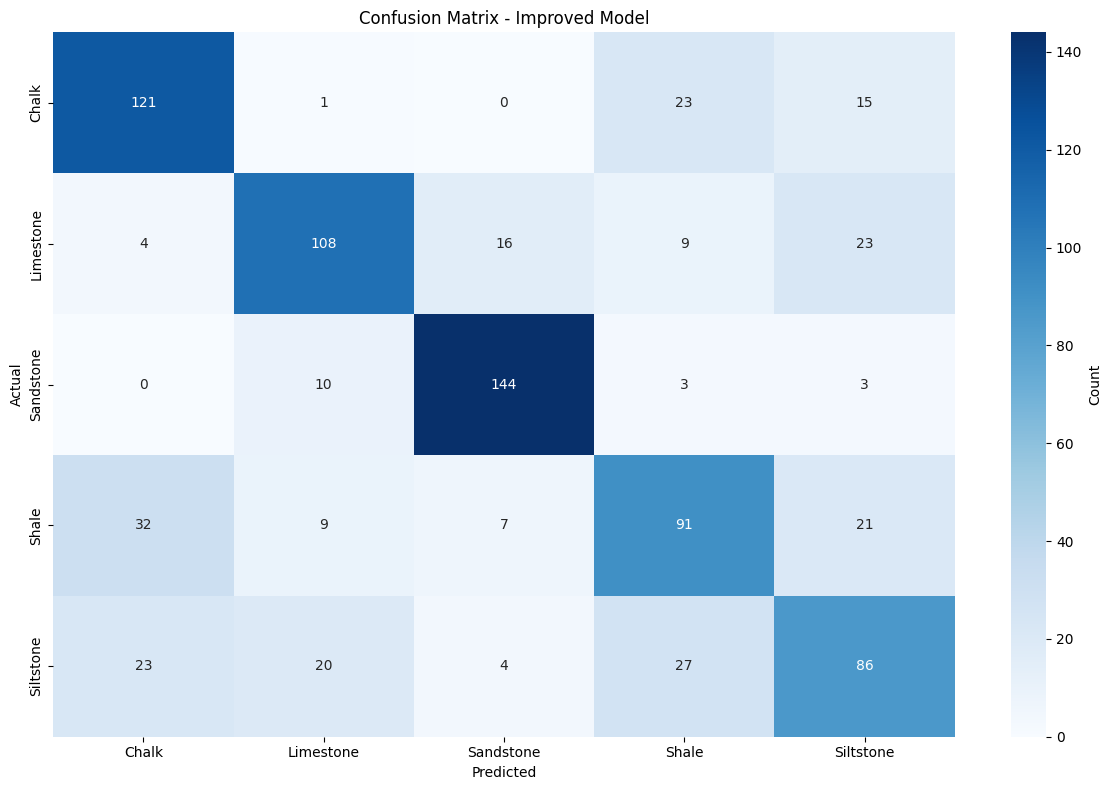

In [36]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - Improved Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

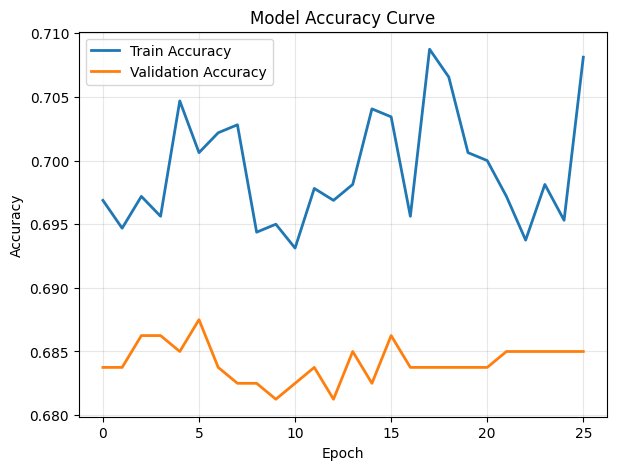

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

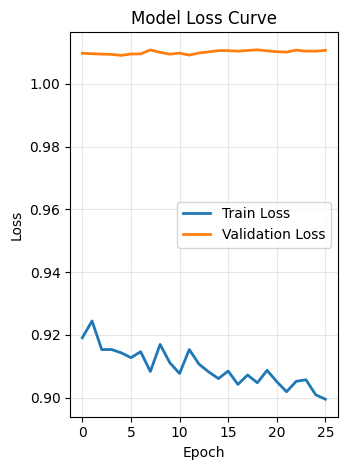

In [38]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculating feature importance...


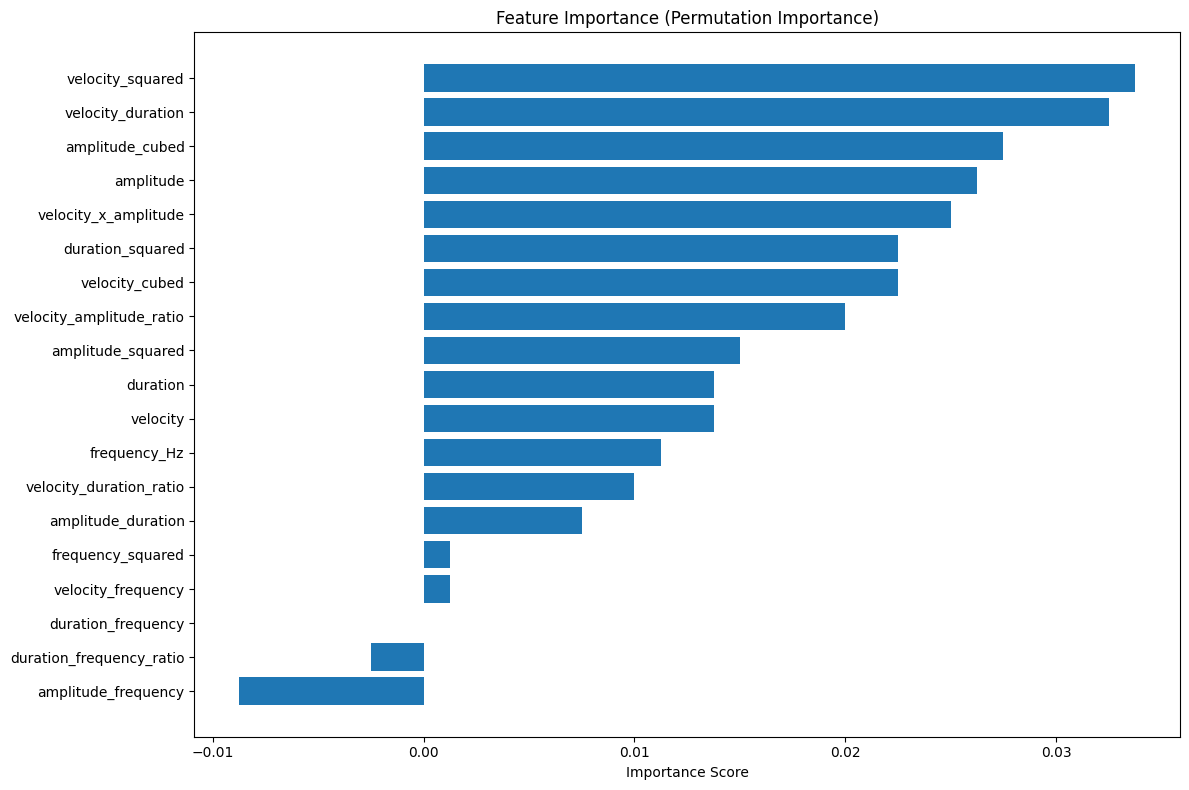

In [39]:
def get_feature_importance(model, X_test, feature_names):
    """Calculate feature importance using permutation importance"""
    baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    importance_scores = []
    for i, feature in enumerate(feature_names):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_accuracy = model.evaluate(X_test_permuted, y_test, verbose=0)[1]
        importance = baseline_accuracy - permuted_accuracy
        importance_scores.append(importance)
    return importance_scores
print("\nCalculating feature importance...")
importance_scores = get_feature_importance(model, X_test, feature_cols)
plt.figure(figsize=(12, 8))
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [40]:
joblib.dump(scaler, "sedimentary_scaler.pkl")
joblib.dump(le, "sedimentary_label_encoder.pkl")
print(f"\nModel saved as: sedimentary_model.keras")
print(f"Scaler saved as: sedimentary_scaler.pkl")
print(f"Label encoder saved as: sedimentary_label_encoder.pkl")
print(f"Final accuracy: {accuracy:.4f}")



Model saved as: sedimentary_model.keras
Scaler saved as: sedimentary_scaler.pkl
Label encoder saved as: sedimentary_label_encoder.pkl
Final accuracy: 0.6875


In [43]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
model = load_model("sedimentary_model.keras")
scaler = joblib.load("sedimentary_scaler.pkl")
le = joblib.load("sedimentary_label_encoder.pkl")
def engineer_features(velocity, amplitude, duration, frequency_hz):
    features = [velocity, amplitude, duration, frequency_hz]
    velocity_x_amplitude = velocity * amplitude
    velocity_squared = velocity ** 2
    duration_squared = duration ** 2
    amplitude_duration = amplitude * duration
    velocity_frequency = velocity * frequency_hz
    amplitude_frequency = amplitude * frequency_hz
    duration_frequency = duration * frequency_hz
    velocity_duration = velocity * duration
    amplitude_squared = amplitude ** 2
    frequency_squared = frequency_hz ** 2
    velocity_amplitude_ratio = velocity / amplitude
    duration_frequency_ratio = duration / frequency_hz
    velocity_duration_ratio = velocity / duration
    velocity_cubed = velocity ** 3
    amplitude_cubed = amplitude ** 3
    all_features = [
        velocity, amplitude, duration, frequency_hz,
        velocity_x_amplitude, velocity_squared, duration_squared,
        amplitude_duration, velocity_frequency, amplitude_frequency,
        duration_frequency, velocity_duration, amplitude_squared,
        frequency_squared, velocity_amplitude_ratio, duration_frequency_ratio,
        velocity_duration_ratio, velocity_cubed, amplitude_cubed
    ]
    return np.array(all_features).reshape(1, -1)
def predict_rock_type(velocity, amplitude, duration, frequency_hz, verbose=True):
    sample_features = engineer_features(velocity, amplitude, duration, frequency_hz)
    sample_scaled = scaler.transform(sample_features)
    pred_prob = model.predict(sample_scaled, verbose=0)
    pred_index = np.argmax(pred_prob)
    pred_label = le.inverse_transform([pred_index])[0]
    confidence = np.max(pred_prob)
    if verbose:
        print(f"\n🪨 Input Sample:")
        print(f"   Velocity: {velocity} km/s")
        print(f"   Amplitude: {amplitude}")
        print(f"   Duration: {duration} ms")
        print(f"   Frequency: {frequency_hz} Hz")
        print(f"\n📊 Prediction Results:")
        print(f"   Predicted Rock Type: {pred_label}")
        print(f"   Confidence: {confidence:.3f}")
        print(f"\n📈 All Probabilities:")
        for i, rock_type in enumerate(le.classes_):
            print(f"   {rock_type}: {pred_prob[0][i]:.3f}")
    return pred_label, confidence, pred_prob[0]
if __name__ == "__main__":
    velocity = 2.50
    amplitude = 0.41
    duration = 182
    frequency_hz = 29
    rock_type, confidence, probabilities = predict_rock_type(
        velocity, amplitude, duration, frequency_hz
    )
    print(f"\nFinal Result: {rock_type} (Confidence: {confidence:.3f})")


🪨 Input Sample:
   Velocity: 2.5 km/s
   Amplitude: 0.41
   Duration: 182 ms
   Frequency: 29 Hz

📊 Prediction Results:
   Predicted Rock Type: Sandstone
   Confidence: 0.974

📈 All Probabilities:
   Chalk: 0.001
   Limestone: 0.013
   Sandstone: 0.974
   Shale: 0.012
   Siltstone: 0.001

Final Result: Sandstone (Confidence: 0.974)
